In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing

## Dataset

This is the Occupancy Detection Data Set, UCI as used in the article how-to-predict-room-occupancy-based-on-environmental-factors

In [112]:
Path="/content/drive/MyDrive/datatest.txt"

In [113]:
occ_data = pd.read_csv(Path)
occ_data = occ_data.set_index('date')

In [114]:
occ_data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


## Preprocessing

In [115]:
occ_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2665 entries, 2015-02-02 14:19:00 to 2015-02-04 10:43:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    2665 non-null   float64
 1   Humidity       2665 non-null   float64
 2   Light          2665 non-null   float64
 3   CO2            2665 non-null   float64
 4   HumidityRatio  2665 non-null   float64
 5   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 145.7+ KB


**check whether each column of the data is stationary or not using the ADF (Augmented-Dickey Fuller) test.**

In [116]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [117]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}

In [118]:
adf_test_results

{'Temperature': 'Non-Stationary',
 'Humidity': 'Non-Stationary',
 'Light': 'Non-Stationary',
 'CO2': 'Non-Stationary',
 'HumidityRatio': 'Non-Stationary',
 'Occupancy': 'Non-Stationary'}

**convert each column of the data to stationary using the differencing way**

In [119]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in occ_data.columns:
    occ_data[col] = differencing(occ_data, col, 1)

In [120]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}

In [121]:
adf_test_results

{'Temperature': 'Stationary',
 'Humidity': 'Stationary',
 'Light': 'Stationary',
 'CO2': 'Stationary',
 'HumidityRatio': 'Stationary',
 'Occupancy': 'Stationary'}

In [122]:
def plot_graph(data,columns):
  df=data.copy()
  font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
  font_legend = {'size': 12, 'family': 'serif'}

  fig, axs = plt.subplots(len(columns), 1,figsize=(10, 20))
  for i in range(len(columns)):
        axs[i].plot(df.index,df[columns[i]], label=columns[i], color='#2f83e4')
        axs[i].set_xlabel('Time', fontdict=font)
        axs[i].set_ylabel('Data', fontdict=font)
        axs[i].legend(loc='upper left', prop=font_legend)

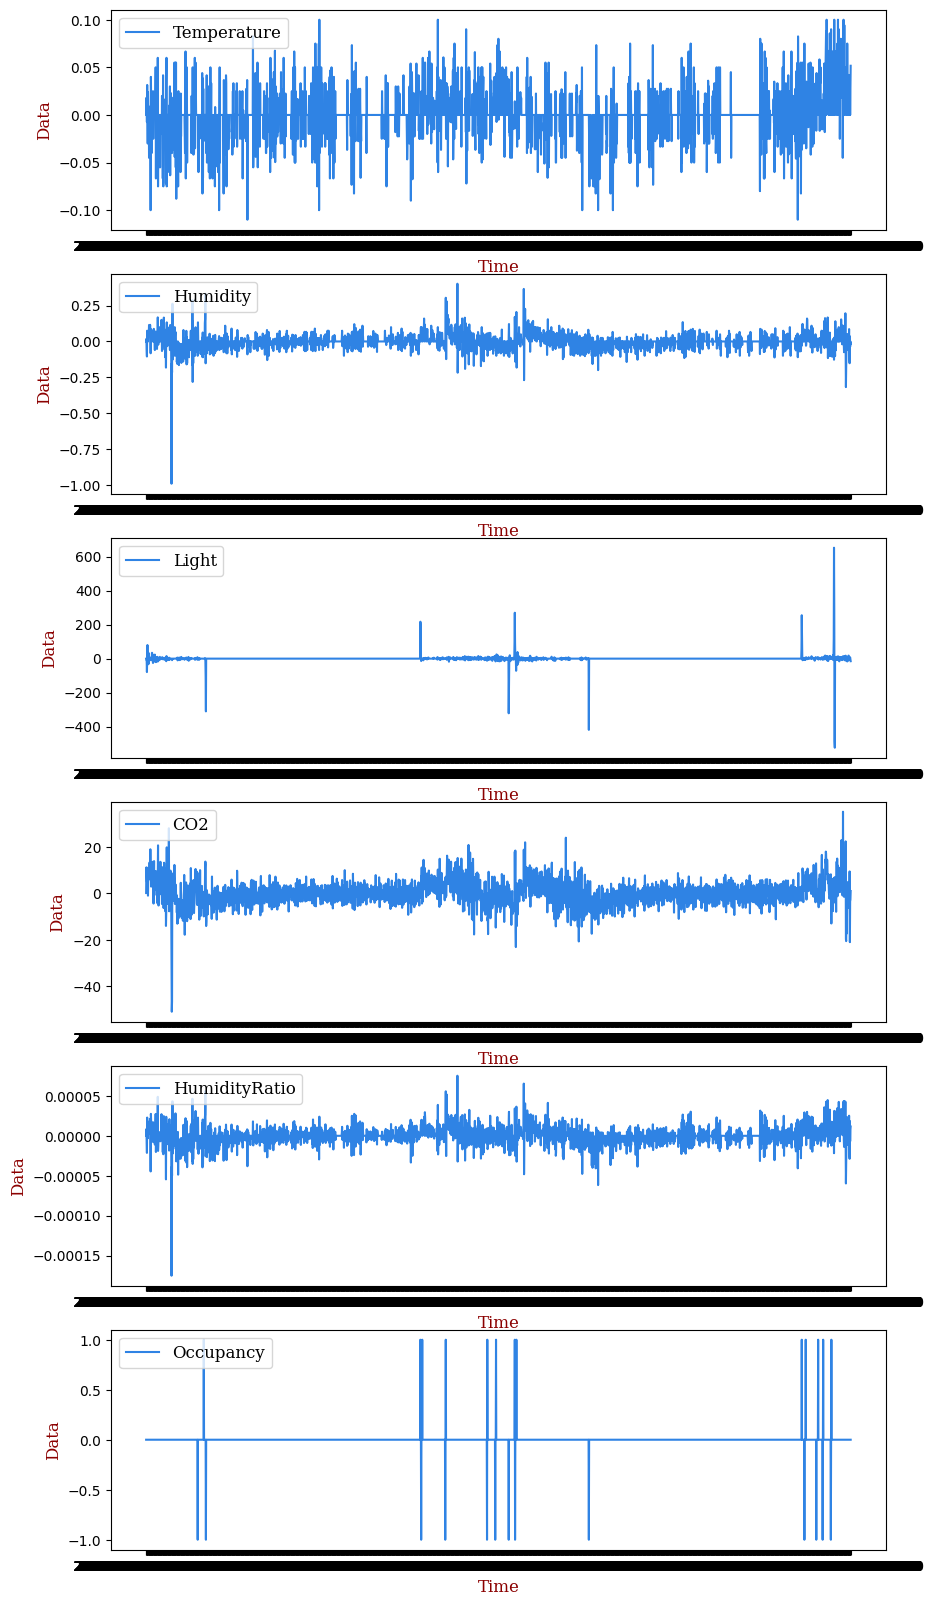

In [123]:
plot_graph(occ_data,occ_data.columns)

## VAR (Vector Auto-Regression)

In [124]:
from statsmodels.tsa.api import VAR
max_lag = 20
var_model = VAR(occ_data)
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


13


The select_order method of VAR is used to find the best lag for the data. In our case, the best order for the lag is 13, which gives us the minimum AIC value for the model.

The VAR model uses the lags of every column of the data as features and the columns in the provided data as targets. The VAR model is going to fit the generated features and fit the least-squares or linear regression by using every column of the data as targets separately.

The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.

In [125]:
def find_anomalies(squared_errors,z=1):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(occ_data)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [126]:
data = occ_data.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

<ipython-input-126-19d4e56cf446>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predictions'] = predictions.values


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Predictions
date,,,,,,,
2015-02-02 14:31:59,0.000000,0.100000,-6.25,13.333333,0.000018,0.0,0
2015-02-02 14:32:59,0.000000,0.074000,-5.00,7.066667,0.000014,0.0,0
2015-02-02 14:34:00,0.000000,0.116000,0.00,8.600000,0.000021,0.0,0
2015-02-02 14:35:00,0.000000,0.082500,-9.00,19.000000,0.000015,0.0,0
2015-02-02 14:36:00,-0.100000,-0.082500,-1.00,11.000000,-0.000045,0.0,0
...,...,...,...,...,...,...,...
2015-02-04 10:38:59,0.000000,-0.152000,6.60,9.450000,-0.000029,0.0,0
2015-02-04 10:40:00,0.040000,0.036000,1.80,-21.050000,0.000019,0.0,0
2015-02-04 10:40:59,0.000000,-0.036000,7.20,-3.400000,-0.000007,0.0,0


In [127]:
data["Predictions"].value_counts()

0    2635
1      17
Name: Predictions, dtype: int64

In [128]:
extracted_data = data[data['Predictions'] == 1].drop('Predictions', axis=1)

In [129]:
def plot_anomalies(data,anomalies_data,columns):
  df=data.copy()
  anomalies_data=anomalies_data.copy()
  font = {'color': 'darkred', 'size': 12, 'family': 'serif'}
  font_legend = {'size': 12, 'family': 'serif'}

  fig, axs = plt.subplots(len(columns), 1,figsize=(10, 20))
  for i in range(len(columns)):
        axs[i].plot(df.index,df[columns[i]], label=columns[i], color='#2f83e4')
        axs[i].scatter(anomalies_data.index, anomalies_data[columns[i]], label="Anomaly",color="r",zorder=5)
        axs[i].set_xlabel('Time', fontdict=font)
        axs[i].set_ylabel('Data', fontdict=font)
        axs[i].legend(loc='upper left', prop=font_legend)

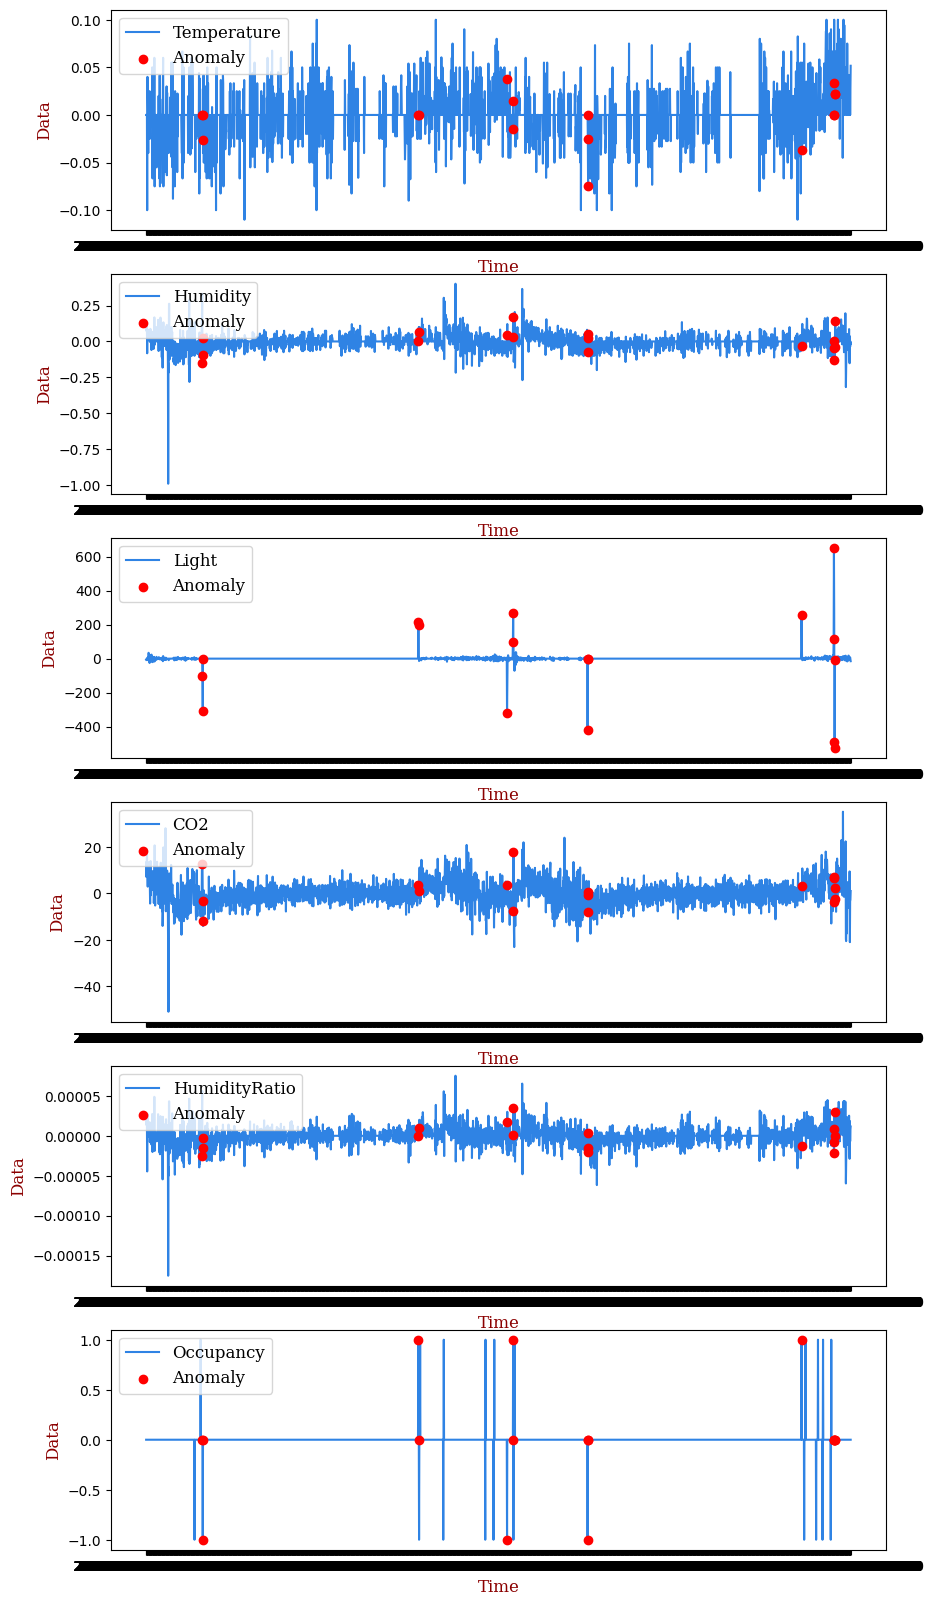

In [130]:
plot_anomalies(data,extracted_data,occ_data.columns)

## VARMAX

In [131]:
data=occ_data.copy()

In [132]:
from statsmodels.tsa.api import VARMAX

In [133]:
varmax_model = VARMAX(occ_data,order=(1,1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [134]:
res = varmax_model.fit(maxiter=1000, disp=False)

/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.72924e-24): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.54367e-20): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [135]:
print(res.summary())

                                                       Statespace Model Results                                                      
Dep. Variable:     ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']   No. Observations:                 2665
Model:                                                                            VARMA(1,1)   Log Likelihood               25473.945
                                                                                 + intercept   AIC                         -50749.890
Date:                                                                       Thu, 20 Jul 2023   BIC                         -50166.982
Time:                                                                               13:55:14   HQIC                        -50538.953
Sample:                                                                                    0                                         
                                                              

In [136]:
squared_errors = res.resid.sum(axis=1) ** 2

In [137]:
predictions, threshold = find_anomalies(squared_errors)

In [138]:
data['Predictions'] = predictions.values

In [139]:
extracted_data = data[data['Predictions'] == 1].drop('Predictions', axis=1)

In [140]:
data["Predictions"].value_counts()

0    2651
1      14
Name: Predictions, dtype: int64

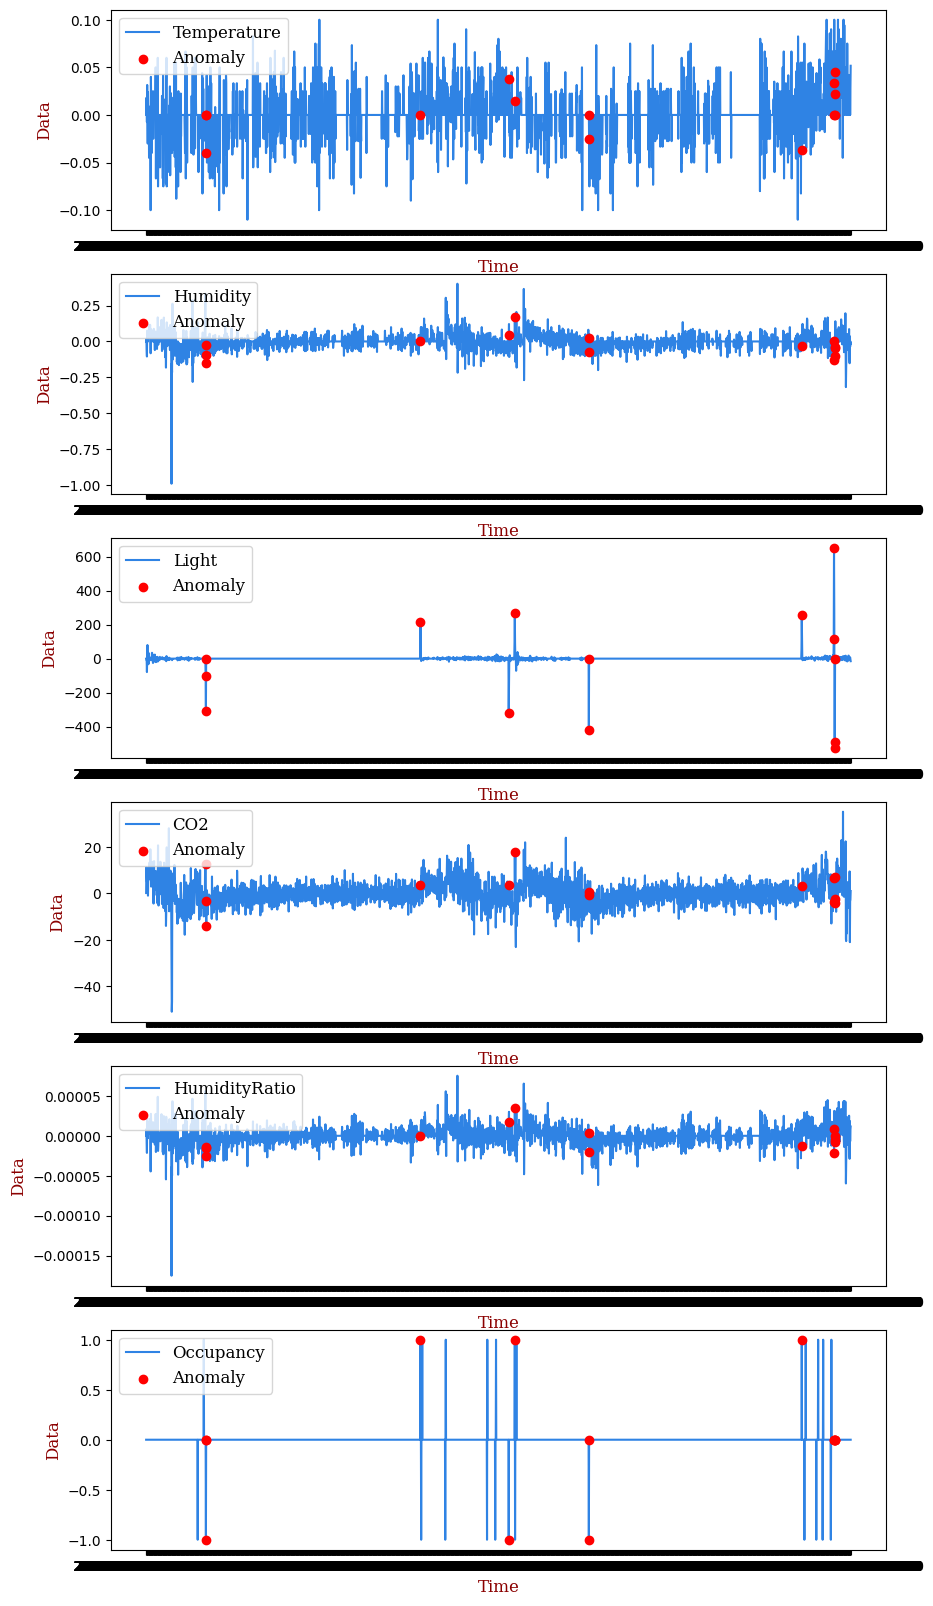

In [141]:
plot_anomalies(data,extracted_data,occ_data.columns)

## VECM

In [142]:
data=occ_data.copy()

In [143]:
occ_data.shape

(2665, 6)

In [144]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [145]:
vecm_model = VECM(occ_data,deterministic="co",k_ar_diff=13)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [146]:
res=vecm_model.fit()

In [147]:
res.resid.shape

(2651, 6)

In [148]:
res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0001,0.000,0.290,0.772,-0.001,0.001
L1.Temperature,-1.5607,0.103,-15.096,0.000,-1.763,-1.358
L1.Humidity,-0.1387,0.069,-2.004,0.045,-0.274,-0.003
L1.Light,0.0002,5.81e-05,2.904,0.004,5.48e-05,0.000
L1.CO2,0.0002,0.000,1.578,0.114,-4.24e-05,0.000
L1.HumidityRatio,848.8229,409.239,2.074,0.038,46.730,1650.916
L1.Occupancy,-0.1034,0.034,-3.068,0.002,-0.169,-0.037
L2.Temperature,-1.8516,0.168,-11.028,0.000,-2.181,-1.523
L2.Humidity,-0.3109,0.111,-2.792,0.005,-0.529,-0.093
L2.Light,0.0002,5.69e-05,3.201,0.001,7.05e-05,0.000


In [149]:
squared_errors = res.resid.sum(axis=1) ** 2

In [150]:
squared_errors.shape

(2651,)

In [151]:
predictions, threshold = find_anomalies(squared_errors)

In [153]:
data = occ_data.iloc[selected_lag+1:, :]
data['Predictions'] = predictions

<ipython-input-153-f3a5124c5463>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predictions'] = predictions


In [154]:
data["Predictions"].value_counts()

0    2633
1      18
Name: Predictions, dtype: int64

In [155]:
extracted_data = data[data['Predictions'] == 1].drop('Predictions', axis=1)

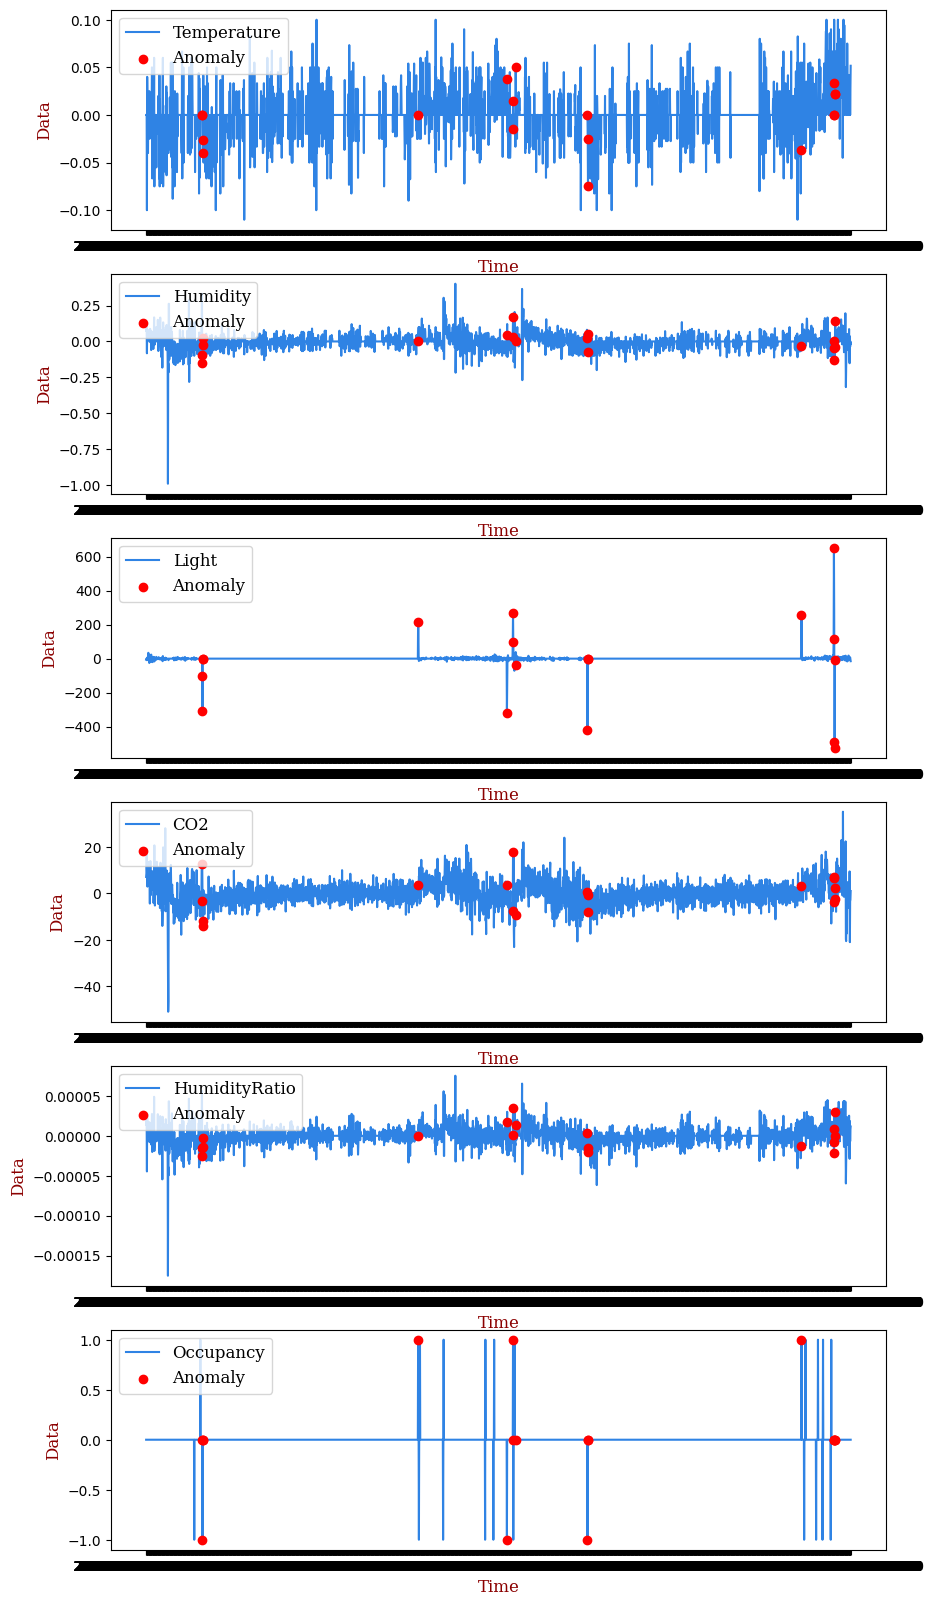

In [156]:
plot_anomalies(data,extracted_data,occ_data.columns)